In [ ]:
!pip install -q scikit-learn pandas matplotlib seaborn nltk

In [ ]:
 import pandas as pd
 import numpy as np
 import matplotlib.pyplot as plt
 import seaborn as sns
 import re
 import string
 from sklearn.model_selection import train_test_split
 from sklearn.feature_extraction.text import TfidfVectorizer
 from sklearn.linear_model import LogisticRegression
 from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
 import nltk
 nltk.download('stopwords')
 from nltk.corpus import stopwords
 STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# example: download McIntire's CSV from GitHub (replace URL if you use another dataset)

df = pd.read_csv('dataset/fake_and_real_news_dataset.csv')
df.head()


,idd,title,text,label
0,Fq+C96tcx+,‘A target on Roe v. Wade ’: Oklahoma bill maki...,UPDATE: Gov. Fallin vetoed the bill on Friday....,REAL
1,bHUqK!pgmv,Study: women had to drive 4 times farther afte...,Ever since Texas laws closed about half of the...,REAL
2,4Y4Ubf%aTi,"Trump, Clinton clash in dueling DC speeches","Donald Trump and Hillary Clinton, now at the s...",REAL
3,_CoY89SJ@K,Grand jury in Texas indicts activists behind P...,A Houston grand jury investigating criminal al...,REAL
4,+rJHoRQVLe,"As Reproductive Rights Hang In The Balance, De...",WASHINGTON -- Forty-three years after the Supr...,REAL


In [ ]:
print("shape:", df.shape)
df['label'] = df['label'].map({'REAL':0, 'FAKE':1})  # adjust based on dataset labels
print(df.label.value_counts())
 # show some examples
for i, row in df.sample(3).iterrows():
  print("----")
  print("label:", row['label'])
  print(row['text'][:400])

shape: (4594, 4)
label
0    2297
1    2297
Name: count, dtype: int64
----
label: 1
Trump warned his supporters that the US Postal Service is trying to steal the election for Hillary Clinton in Colorado. 
Video: 
At a rally in Golden, CO, Trump said: 
I have real problems with ballots being sent. Does that make sense? 
Like people saying, “Oh, here’s a ballot. Here’s another ballot. Throw it away. Oh, here’s one I like. We’ll keep that one.” 
I have real problems, so get your bal
----
label: 0
Taya Kyle is the author of "American Wife: A Memoir of Love, War, Faith, and Renewal." Her late husband, Chris Kyle, was the subject of the movie, "American Sniper." Taya Kyle was an invited guest for the CNN Town Hall " Guns in America ." Follow her on Twitter: @TayaKyle . The opinions expressed in this commentary are hers.

(CNN) Many of us taking part in the CNN town hall on guns have been touc
----
label: 0
With the shake of an Etch-A-Sketch, Mitt Romney reintroduced himself to the Republican 

In [ ]:
def clean_text(text):
  if not isinstance(text, str):
    return ""
  text = text.lower()
  text = re.sub(r'\n', ' ', text)
  text = re.sub(r'https?://\S+|www\.\S+', '', text)  # remove URLs
  text = re.sub(r'[^a-z0-9 ]', ' ', text)
# keep alphanum
  tokens = [t for t in text.split() if t not in STOPWORDS and len(t)>1]
  return " ".join(tokens)
df['clean'] = df['text'].apply(clean_text)

In [ ]:
 X = df['clean']
 y = df['label']
 X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
 X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
 print(X_train.shape, X_val.shape, X_test.shape)

(3215,) (689,) (690,)


In [ ]:
 tf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
 X_train_tfidf = tf.fit_transform(X_train)
 X_val_tfidf = tf.transform(X_val)
 X_test_tfidf = tf.transform(X_test)
 model = LogisticRegression(max_iter=1000)
 model.fit(X_train_tfidf, y_train)
 y_pred = model.predict(X_val_tfidf)
 print("VAL accuracy:", accuracy_score(y_val, y_pred))
 print(classification_report(y_val, y_pred, digits=4))

VAL accuracy: 0.9114658925979681
              precision    recall  f1-score   support

           0     0.9465    0.8725    0.9080       345
           1     0.8814    0.9506    0.9147       344

    accuracy                         0.9115       689
   macro avg     0.9140    0.9115    0.9113       689
weighted avg     0.9140    0.9115    0.9113       689



TEST accuracy: 0.9028985507246376
              precision    recall  f1-score   support

           0     0.9455    0.8551    0.8980       345
           1     0.8677    0.9507    0.9073       345

    accuracy                         0.9029       690
   macro avg     0.9066    0.9029    0.9027       690
weighted avg     0.9066    0.9029    0.9027       690



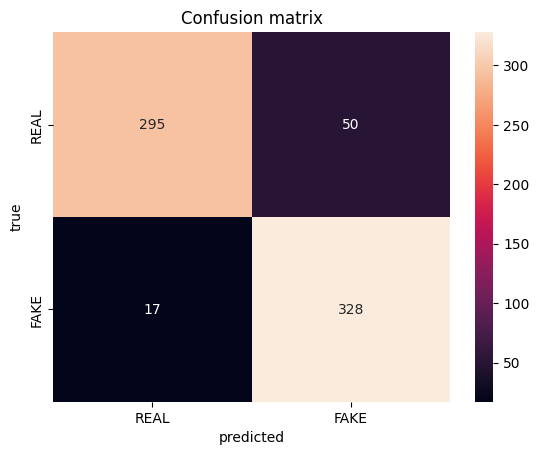

In [ ]:
 y_test_pred = model.predict(X_test_tfidf)
 print("TEST accuracy:", accuracy_score(y_test, y_test_pred))
 print(classification_report(y_test, y_test_pred, digits=4))
 cm = confusion_matrix(y_test, y_test_pred)
 sns.heatmap(cm, annot=True, fmt='d', xticklabels=['REAL','FAKE'], yticklabels=['REAL','FAKE'])
 plt.xlabel('predicted'); plt.ylabel('true'); plt.title('Confusion matrix')
 plt.show()

In [ ]:
 # Function to make prediction on custom news text
 def predict_news(text):
 # Clean the input text using the same preprocessing function used earlier
  cleaned_text = clean_text(text)
  # Transform the cleaned text using the trained TF-IDF vectorizer
  vectorized = tf.transform([cleaned_text])
  # Predict with the trained model
  prediction = model.predict(vectorized)[0]
  # Return result
  return "FAKE NEWS" if prediction == 1 else "REAL NEWS"
  # Asking user to input a news text
 test_news = input("Enter a news headline or article to check if it's Fake or Real:\n")
 print("\nPrediction:", predict_news(test_news))